In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta, date
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [19]:
import os
import functools as ft
files = os.listdir('../Dataset/weather_merged_2')
dfs=[]
for file in files:
    dftmp = pd.read_csv('../Dataset/weather_merged_2'+'/'+file)
    # dfs.append(dftmp.sample(n=5000))
    dftmp.drop('year', axis=1, inplace=True)
    dftmp.drop('month', axis=1, inplace=True)
    dftmp.drop('REPORT_ID', axis=1, inplace=True)
    dfs.append(dftmp)
# df = pd.concat(dfs)

In [20]:
# df.drop('year', axis=1, inplace=True)
# df.head(3)

In [21]:
# corr = df.corr()
# f, ax = plt.subplots(figsize=(16, 7))
# sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1, vmax=1, square=True, linewidths=1)
# f.suptitle('Heatmap showing the correlation of data attributes', fontsize=20)
# plt.show()

In [22]:
def make_metrics(models):
    data = {
        'name': [model.name for model in models[1:]],
        'r2': [model.r2 for model in models[1:]],
        'rmse': [model.rmse for model in models[1:]]
    }
    data['name'] = 'average R2 and sum RMSE'
    data['r2'].append(np.mean(data['r2']))
    data['rmse'].append(np.sum(data['rmse']))
    return pd.DataFrame(data)

In [23]:
class Model:
  def __init__(self, name, data, predict_features, test_size, ml_model):
    self.name = name
    self.data = data
    self.predict_features = predict_features
    self.is_trained = False
    self.test_size = test_size
    self.ml_model = ml_model
    self.do_things()

  def cal_rmse(self):
    self.rmse = mean_squared_error(self.ytest, self.ypredict, squared=False)
    return self.rmse

  def prequisite(self, test_size):
    self.features = [i for i in self.data.columns if i != self.predict_features]
    self.X = self.data[self.features].values
    self.y = self.data[self.predict_features].values
    self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(self.X, self.y, test_size=test_size)
    return None

  def fit(self):
    self.is_trained = True
    self.ml_model.fit(self.Xtrain, self.ytrain)
    self.ypredict = self.ml_model.predict(self.Xtest)
    return self.ml_model

  def cal_r2_score(self):
    self.r2 = r2_score(self.ytest, self.ypredict)
    return self.r2

  def do_things(self) -> None:
    self.prequisite(self.test_size)
    self.fit()
    self.cal_rmse()
    self.cal_r2_score()
    return None

  def __repr__(self) -> str:
    if not self.is_trained:
      return f'<{self.name}> (is not trained yet)>'
    return f'<({self.name}: [R² Score: {self.r2}], [RMSE: {self.rmse}])>'

In [24]:
def getreport_id (df):
    return df['REPORT_ID'].unique()

In [26]:
models = [None]
# list_report_id = getreport_id(df)
for i in range(0,len(dfs)):
    # report_id = dfs[i]['REPORT_ID'][0]
    models += [
        Model(
            ml_model=linear_model.LinearRegression(),
            name=f'Dataset of report {i}',
            data=dfs[i],
            predict_features='vehicleCount',
            test_size=1/4
        )
    ]
    
make_metrics(models)

,name,r2,rmse
0,average R2 and sum RMSE,0.394905,41.708569
1,average R2 and sum RMSE,0.128234,51.478605
2,average R2 and sum RMSE,0.553215,26.909995
3,average R2 and sum RMSE,0.351256,25.853620
4,average R2 and sum RMSE,0.082229,153.900628
...,...,...,...
445,average R2 and sum RMSE,0.048438,3.088791
446,average R2 and sum RMSE,0.022878,2.763067
447,average R2 and sum RMSE,0.028339,2.245886
448,average R2 and sum RMSE,0.078031,2.183446


In [32]:
#make histogram
def make_histogram(df, feature):
    df['r2']= df['r2'].apply(lambda x: x*100)
    df = df[df['r2']>0]
    plt.figure(figsize=(12, 6))
    plt.hist(df[feature], bins=100)
    plt.title(f'Histogram of {feature}', fontsize=20)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.show()

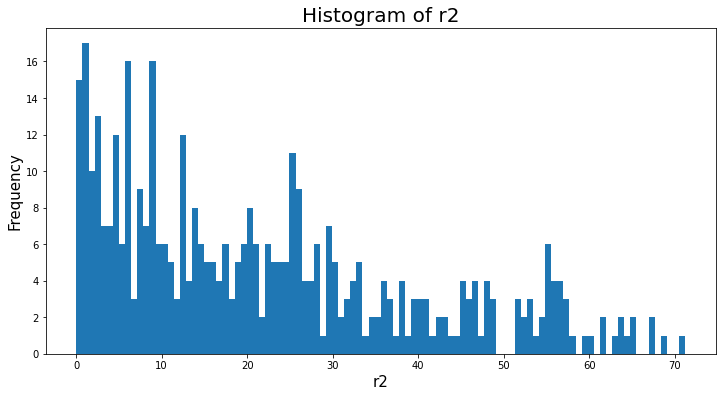

In [33]:
make_histogram(make_metrics(models), 'r2')